In [ ]:
## I want to patch the last few gaps in the pan_dataset_values

In [2]:
dataset_name = "W19_comb"
df_list = [ "BES_Panel", "BES_reduced_with_na"]

In [3]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
    else:
        globals()[df]  = pd.read_pickle(data_subfolder + df + '.zip',compression='zip' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )
pan_dataset_votes = pd.read_pickle(BES_small_data_files + "pan_dataset_votes"+".zip", compression='zip')

Toggle code

var_type (7911, 14)


In [217]:
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")

In [5]:
pan_dataset_allr_values.isnull().sum()


Economic: Left(0) <-> Right(200){uniform}               2665
Social: Liberalism(0) <-> Conservatism(200){uniform}    2665
Economic: Left <-> Right{gaussian-ish}                  2665
Social: Liberalism <-> Conservatism{gaussian-ish}       2665
id                                                         0
dtype: int64

In [6]:
BES_vals = pd.concat([ pd.read_pickle(BES_R_data_files + dataset_name + "lr_values" + "_Hmisc" + '.zip' ),
                       pd.read_pickle(BES_R_data_files + dataset_name + "al_values" + "_Hmisc" + '.zip' ),],axis=1)

Index(['Economic: Left(0) <-> Right(200){uniform}',
       'Social: Liberalism(0) <-> Conservatism(200){uniform}',
       'Economic: Left <-> Right{gaussian-ish}',
       'Social: Liberalism <-> Conservatism{gaussian-ish}', 'id'],
      dtype='object')

In [7]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    

import shap
import xgboost as xgb
# from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves, mask)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values, train.columns, alg)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#     return BES_Panel["generalElectionVoteW19"].notnull()
    return 1



def create_train(drop_other_waves,mask):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list][mask].astype('float32')


def create_target(target_var):
    
    return df[target_var].astype('float32')

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.03,
 n_estimators= 600,
 max_depth=6,
 min_child_weight=8,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)

# wave_pair = ["W8","W9"]
def add_pairs(wave_pair):
    pair1_cols = [x for x in search(df,wave_pair[0]).index if x.replace(wave_pair[0],wave_pair[1]) in df.columns]
    pair2_cols = [x.replace(wave_pair[0],wave_pair[1]) for x in pair1_cols]

    prefix = "D"+"_".join([x.replace("W","") for x in wave_pair])
    delta_df = pd.DataFrame(df[pair2_cols].values - df[pair1_cols].values,
                            columns = [prefix+x.replace(wave_pair[0],"") for x in pair1_cols])
    if pair1_cols!=[]:
        biggest_dtype = df[pair1_cols].dtypes.value_counts().index[-1].name
        biggest_dtype = "Int64" # nino_df screws this up by introducing floats!
        delta_df = delta_df.astype(biggest_dtype).astype('float32')
        df[delta_df.columns] = delta_df
    
def shap_array(shap_values, train_columns, threshold = .1, min_features = 50):

    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    return pd.Series(global_shap_vals[inds][::-1],index = train_columns[inds][::-1])    

def hash_df(sourcedf,destinationdf,*column):
    columnName = ''
    destinationdf['hash_'+columnName.join(column)] = pd.DataFrame(sourcedf[list(column)].values.sum(axis=1))[0].str.encode('utf-8').apply(lambda x: (hashlib.sha512(x).hexdigest().upper()))
# hash_df(df,df,'ID','Salt')

def drop_duplicate_columns(df):
    return df.loc[:,~df.columns.duplicated()]

In [8]:
nowtsW19 = (BES_Panel["wt_new_W19_result"].isnull() & BES_Panel["wave19"])

In [13]:
genuine_missing_values = (pan_dataset_allr_values.isnull()[pan_dataset_allr_values.columns[0]] & ~nowtsW19)

In [21]:
narrow_missing_values = BES_vals.isnull().all(axis=1) & ~nowtsW19
narrow_missing_values.sum()

1438

In [ ]:
## which entries

In [17]:
BES_Panel[search(BES_Panel,"wave\d+").index][genuine_missing_values].sum()

wave1     259
wave2     244
wave3     188
wave4     280
wave5     229
wave6     119
wave7     218
wave8     221
wave9     170
wave10    321
wave11    250
wave12    244
wave13    159
wave14    265
wave15    302
wave16    534
wave17    379
wave18    347
wave19    278
dtype: int64

In [22]:
BES_Panel[search(BES_Panel,"wave\d+").index][narrow_missing_values].sum()

wave1     130
wave2     136
wave3     113
wave4     204
wave5     181
wave6      80
wave7     151
wave8     164
wave9     121
wave10    219
wave11    169
wave12    172
wave13    102
wave14    186
wave15    185
wave16    380
wave17    247
wave18    227
wave19    173
dtype: int64

In [33]:
BES_reduced_with_na[narrow_missing_values].notnull().sum().sort_values().tail(5000)

mii_catW13_international trade                    33
mii_catW13_unemployment                           33
mii_catW13_transport/infrastructure               33
mii_catW13_war                                    33
ptvBrexitPartyW16__Very likely                    33
                                                ... 
profile_ethnicity_Pakistani                      805
profile_ethnicity_Chinese                        805
profile_ethnicity_Any other black background     805
profile_ethnicity_Black African                  805
gender_Female                                   1275
Length: 5000, dtype: int64

In [54]:
decent_sample_cols = BES_reduced_with_na.columns[BES_reduced_with_na[narrow_missing_values].notnull().sum()>100]


In [46]:
decent_sample_rows = BES_reduced_with_na[decent_sample_cols].notnull().sum(axis=1)>100

In [56]:
train_entries = (decent_sample_rows & ~nowtsW19 & ~genuine_missing_values)

In [50]:
al_values = [x for x in BES_reduced_with_na.columns if re.match("(al)\d",x)]
lr_values = [x for x in BES_reduced_with_na.columns if re.match("(lr)\d",x)]

In [52]:
len([x for x in decent_sample_cols if x not in al_values and x not in lr_values])
# doesn't appear to be necessary to remove these

1794

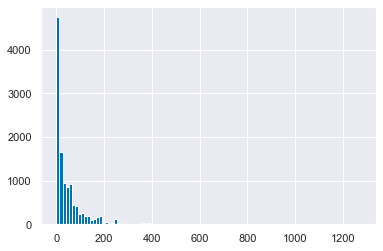

In [28]:
BES_reduced_with_na[narrow_missing_values].notnull().sum().hist(bins=100)

In [57]:
%%time
df = BES_reduced_with_na.loc[train_entries,decent_sample_cols].astype('float32')

Wall time: 38.6 s


[21:20:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.0942
Will train until validation_0-rmse hasn't improved in 60.0 rounds.
[1]	validation_0-rmse:1.06791
[2]	validation_0-rmse:1.04218
[3]	validation_0-rmse:1.0168
[4]	validation_0-rmse:0.992293
[5]	validation_0-rmse:0.968729
[6]	validation_0-rmse:0.945719
[7]	validation_0-rmse:0.923393
[8]	validation_0-rmse:0.901472
[9]	validation_0-rmse:0.880402
[10]	validation_0-rmse:0.859733
[11]	validation_0-rmse:0.83942
[12]	validation_0-rmse:0.819896
[13]	validation_0-rmse:0.800818
[14]	validation_0-rmse:0.782491
[15]	validation_0-rmse:0.764595
[16]	validation_0-rmse:0.747209
[17]	validation_0-rmse:0.730232
[18]	validation_0-rmse:0.71381
[19]	validation_0-rmse:0.697699
[20]	validation_0-rmse:0.681907
[21]	validation_0-rmse:0.666711
[22]	validation_0-rmse:0.651959
[23]	validation_0-rmse:0.63739
[24]	validation_0-rmse:0.62344
[25]	validation_0-rmse:0.609753
[26]	

[248]	validation_0-rmse:0.082935
[249]	validation_0-rmse:0.082785
[250]	validation_0-rmse:0.082653
[251]	validation_0-rmse:0.082505
[252]	validation_0-rmse:0.082345
[253]	validation_0-rmse:0.082192
[254]	validation_0-rmse:0.082046
[255]	validation_0-rmse:0.081917
[256]	validation_0-rmse:0.081774
[257]	validation_0-rmse:0.08168
[258]	validation_0-rmse:0.081551
[259]	validation_0-rmse:0.081429
[260]	validation_0-rmse:0.081316
[261]	validation_0-rmse:0.081165
[262]	validation_0-rmse:0.081065
[263]	validation_0-rmse:0.080944
[264]	validation_0-rmse:0.080812
[265]	validation_0-rmse:0.080706
[266]	validation_0-rmse:0.080567
[267]	validation_0-rmse:0.080473
[268]	validation_0-rmse:0.080357
[269]	validation_0-rmse:0.0802
[270]	validation_0-rmse:0.080086
[271]	validation_0-rmse:0.079973
[272]	validation_0-rmse:0.079885
[273]	validation_0-rmse:0.079787
[274]	validation_0-rmse:0.079672
[275]	validation_0-rmse:0.079586
[276]	validation_0-rmse:0.079505
[277]	validation_0-rmse:0.079408
[278]	validat

[498]	validation_0-rmse:0.063145
[499]	validation_0-rmse:0.063106
[500]	validation_0-rmse:0.063043
[501]	validation_0-rmse:0.063017
[502]	validation_0-rmse:0.062954
[503]	validation_0-rmse:0.062884
[504]	validation_0-rmse:0.062791
[505]	validation_0-rmse:0.062744
[506]	validation_0-rmse:0.062724
[507]	validation_0-rmse:0.062682
[508]	validation_0-rmse:0.062634
[509]	validation_0-rmse:0.062607
[510]	validation_0-rmse:0.062583
[511]	validation_0-rmse:0.062514
[512]	validation_0-rmse:0.062492
[513]	validation_0-rmse:0.062469
[514]	validation_0-rmse:0.062436
[515]	validation_0-rmse:0.062399
[516]	validation_0-rmse:0.062333
[517]	validation_0-rmse:0.062284
[518]	validation_0-rmse:0.062261
[519]	validation_0-rmse:0.062227
[520]	validation_0-rmse:0.062182
[521]	validation_0-rmse:0.062141
[522]	validation_0-rmse:0.062093
[523]	validation_0-rmse:0.062045
[524]	validation_0-rmse:0.062024
[525]	validation_0-rmse:0.061973
[526]	validation_0-rmse:0.061909
[527]	validation_0-rmse:0.061855
[528]	vali

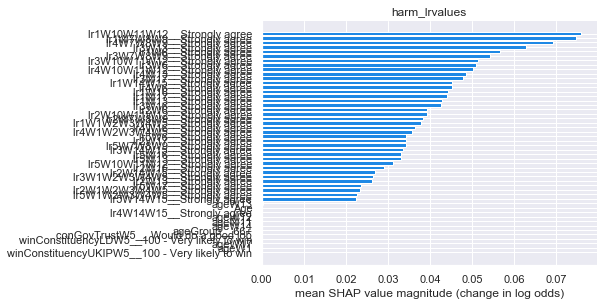

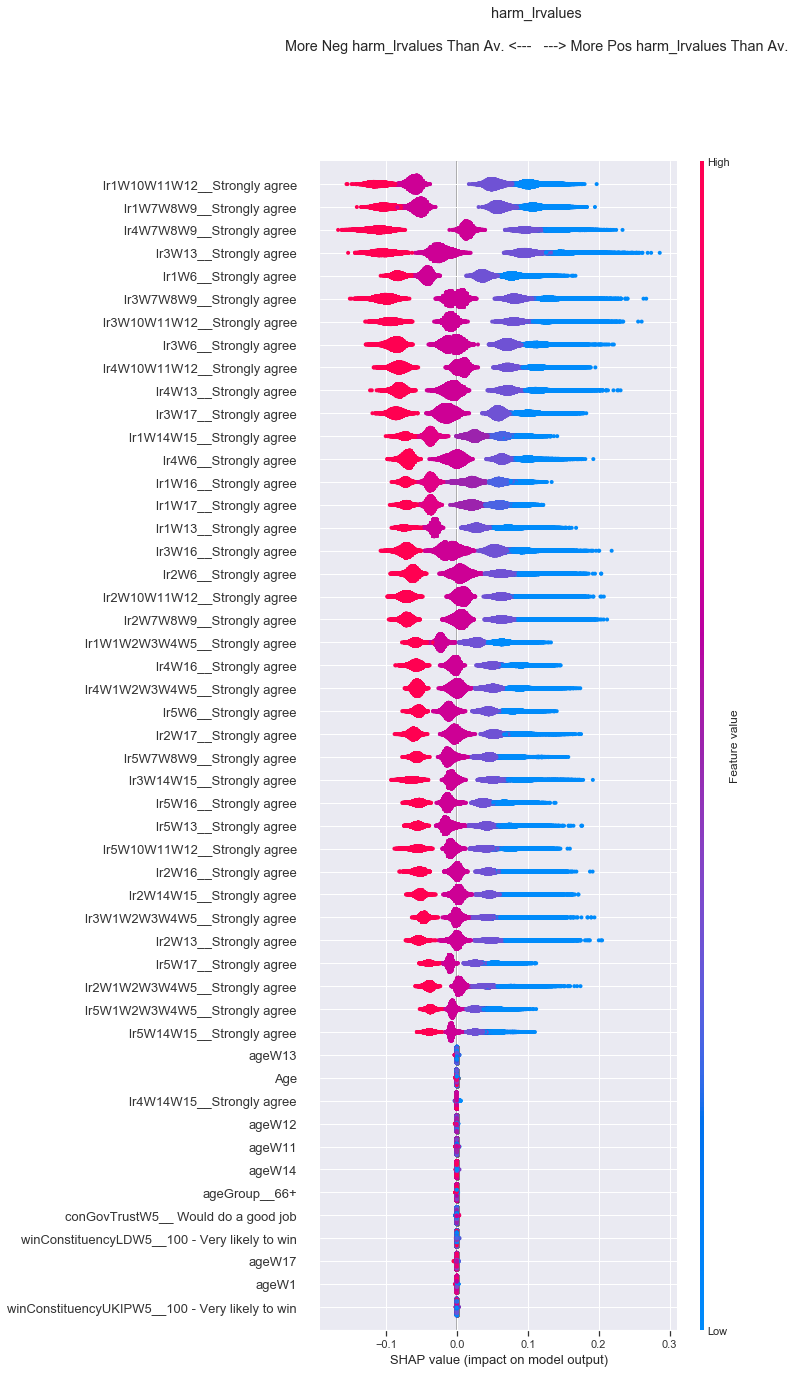

NameError: name 'treatment_dict' is not defined

In [64]:
%%time
# base = "redistSelfW1"

Treatment = "predicted_lr_values"
var1 = "harm_lrvalues"
# BES_reduced_with_na[var1]= Age_at_W1

base = "harm_lrvalues"

# var1 = match(BES_reduced_with_na,base).index[0]

# mask = BES_reduced_with_na[var1].notnull()
# mask.loc[mask.index[::2]] = False

df = BES_reduced_with_na.loc[train_entries,decent_sample_cols].astype('float32')
df[var1] = pan_dataset_allr_values.loc[train_entries,'Economic: Left <-> Right{gaussian-ish}']
df[BES_vals.columns] = BES_vals[train_entries]
# df_temp = pd.get_dummies( BES_Panel[match(BES_Panel,"ageGroup|profile_household_children[^W]|edlevel|profile_education_age[^W]|profile_sexualityW10|sexualityW17|profile_religion[^W]").index] )
# df[df_temp.columns] = df_temp

# df[var1] = Age_at_W1[mask]

var_stub = var1

var_list = [var_stub]
var_stub_list = [var_stub]

(explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
# treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

In [66]:
%%time
df= BES_reduced_with_na.loc[genuine_missing_values,decent_sample_cols].astype('float32')
df[BES_vals.columns] = BES_vals[genuine_missing_values]
lr_broad_1 = alg.predict(df)

Wall time: 4.57 s


In [67]:
%%time
df= BES_reduced_with_na.loc[narrow_missing_values,decent_sample_cols].astype('float32')
df[BES_vals.columns] = BES_vals[narrow_missing_values]
lr_broad_2 = alg.predict(df)

Wall time: 4.32 s


In [68]:
search(BES_Panel,"lr_scale",mask=genuine_missing_values)

lr_scaleW1W2W3W4W5    61
lr_scaleW6             0
lr_scaleW7W8W9         0
lr_scaleW10W11W12      0
lr_scaleW13            0
lr_scaleW14W15         2
lr_scaleW16            2
lr_scaleW17            2
dtype: int64

In [71]:
BES_Panel["lr_scaleW1W2W3W4W5"][BES_Panel["lr_scaleW1W2W3W4W5"].notnull() & genuine_missing_values].cat.codes

2618     20
33601     4
34070    10
36653     5
36916    20
         ..
91694     1
92290     8
92604     9
94537    10
96236     5
Length: 61, dtype: int8

In [76]:
lr_broad_1[genuine_missing_values[BES_Panel["lr_scaleW1W2W3W4W5"].notnull()]]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2036 but corresponding boolean dimension is 38503

In [86]:
fit = lr_broad_1[(BES_Panel["lr_scaleW1W2W3W4W5"].notnull() & genuine_missing_values)[genuine_missing_values]]
vals= BES_Panel["lr_scaleW1W2W3W4W5"][BES_Panel["lr_scaleW1W2W3W4W5"].notnull() & genuine_missing_values].cat.codes.values
pd.DataFrame([fit,vals]).T.corr()

,0,1
0,1.000000,0.492106
1,0.492106,1.000000


[01:29:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.1077
Will train until validation_0-rmse hasn't improved in 59.900000000000006 rounds.
[1]	validation_0-rmse:1.09443
[2]	validation_0-rmse:1.08168
[3]	validation_0-rmse:1.06938
[4]	validation_0-rmse:1.05772
[5]	validation_0-rmse:1.04661
[6]	validation_0-rmse:1.03586
[7]	validation_0-rmse:1.02557
[8]	validation_0-rmse:1.01576
[9]	validation_0-rmse:1.00649
[10]	validation_0-rmse:0.997622
[11]	validation_0-rmse:0.989237
[12]	validation_0-rmse:0.981089
[13]	validation_0-rmse:0.973356
[14]	validation_0-rmse:0.965821
[15]	validation_0-rmse:0.959076
[16]	validation_0-rmse:0.952383
[17]	validation_0-rmse:0.946129
[18]	validation_0-rmse:0.940173
[19]	validation_0-rmse:0.934279
[20]	validation_0-rmse:0.928475
[21]	validation_0-rmse:0.923077
[22]	validation_0-rmse:0.918107
[23]	validation_0-rmse:0.913027
[24]	validation_0-rmse:0.90824
[25]	validation_0-rmse:0.

[247]	validation_0-rmse:0.777111
[248]	validation_0-rmse:0.777059
[249]	validation_0-rmse:0.777004
[250]	validation_0-rmse:0.776947
[251]	validation_0-rmse:0.776885
[252]	validation_0-rmse:0.776829
[253]	validation_0-rmse:0.776733
[254]	validation_0-rmse:0.776676
[255]	validation_0-rmse:0.776639
[256]	validation_0-rmse:0.776566
[257]	validation_0-rmse:0.776513
[258]	validation_0-rmse:0.776446
[259]	validation_0-rmse:0.776383
[260]	validation_0-rmse:0.776308
[261]	validation_0-rmse:0.776225
[262]	validation_0-rmse:0.77617
[263]	validation_0-rmse:0.776137
[264]	validation_0-rmse:0.776105
[265]	validation_0-rmse:0.776066
[266]	validation_0-rmse:0.776035
[267]	validation_0-rmse:0.775976
[268]	validation_0-rmse:0.77593
[269]	validation_0-rmse:0.775892
[270]	validation_0-rmse:0.775816
[271]	validation_0-rmse:0.775772
[272]	validation_0-rmse:0.775728
[273]	validation_0-rmse:0.775662
[274]	validation_0-rmse:0.775625
[275]	validation_0-rmse:0.775596
[276]	validation_0-rmse:0.775552
[277]	valida

[497]	validation_0-rmse:0.768801
[498]	validation_0-rmse:0.768805
[499]	validation_0-rmse:0.768797
[500]	validation_0-rmse:0.768784
[501]	validation_0-rmse:0.768786
[502]	validation_0-rmse:0.76878
[503]	validation_0-rmse:0.768767
[504]	validation_0-rmse:0.768733
[505]	validation_0-rmse:0.768724
[506]	validation_0-rmse:0.768676
[507]	validation_0-rmse:0.768648
[508]	validation_0-rmse:0.768629
[509]	validation_0-rmse:0.768579
[510]	validation_0-rmse:0.768566
[511]	validation_0-rmse:0.768569
[512]	validation_0-rmse:0.76853
[513]	validation_0-rmse:0.768531
[514]	validation_0-rmse:0.768495
[515]	validation_0-rmse:0.768489
[516]	validation_0-rmse:0.768486
[517]	validation_0-rmse:0.768473
[518]	validation_0-rmse:0.768474
[519]	validation_0-rmse:0.768439
[520]	validation_0-rmse:0.768437
[521]	validation_0-rmse:0.768427
[522]	validation_0-rmse:0.768413
[523]	validation_0-rmse:0.768389
[524]	validation_0-rmse:0.768367
[525]	validation_0-rmse:0.768349
[526]	validation_0-rmse:0.768374
[527]	valida

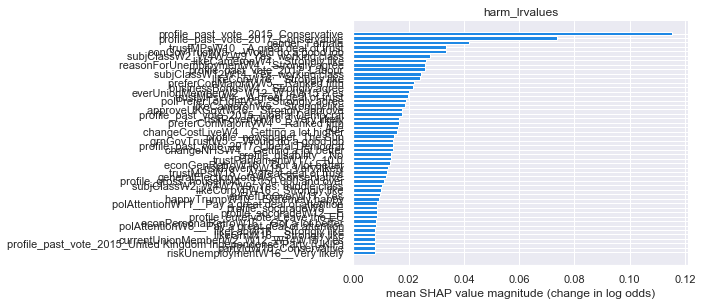

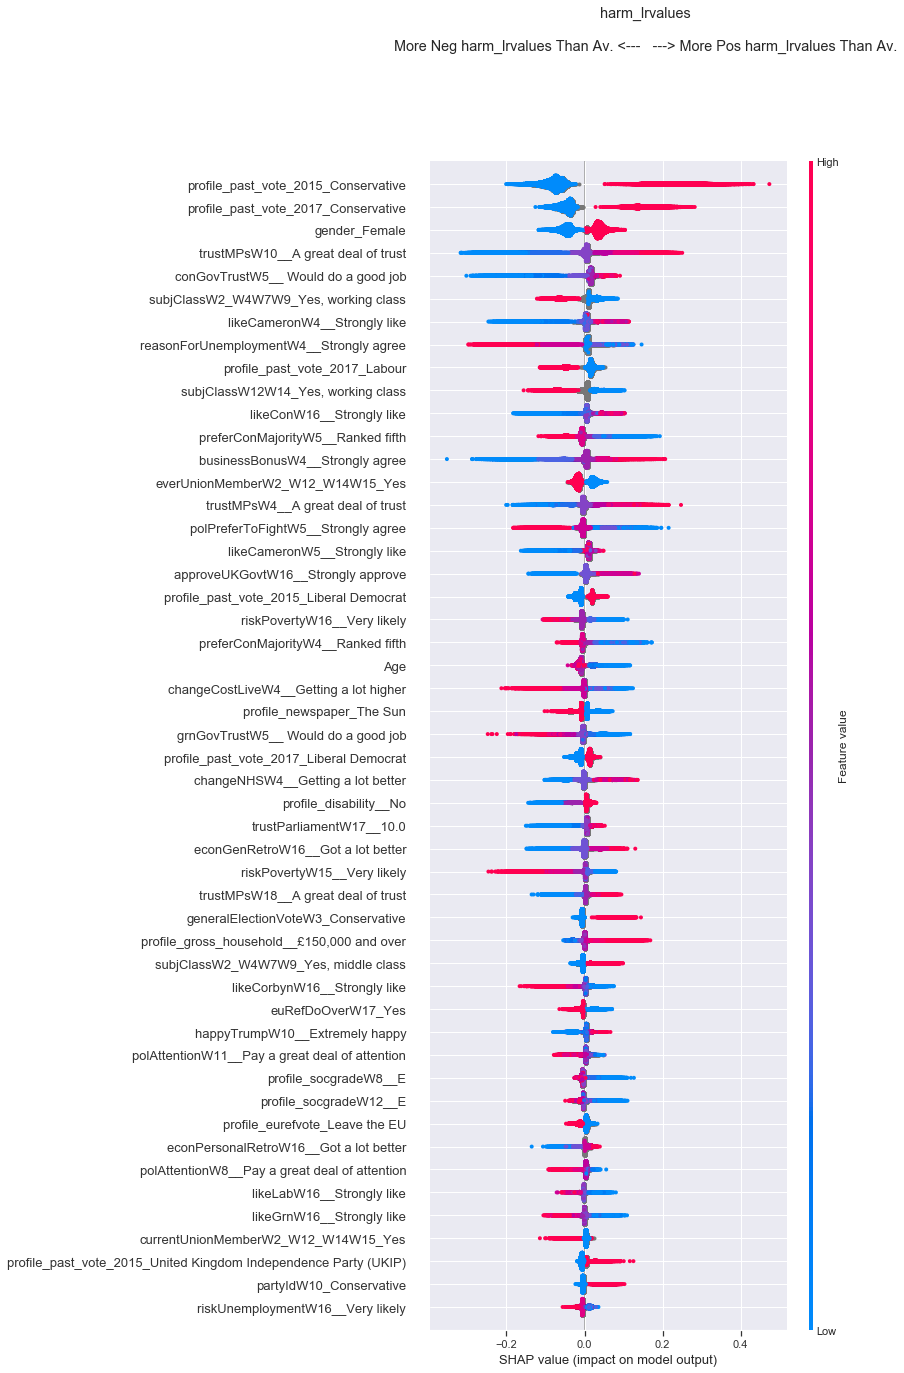

Wall time: 1h 45min 33s


In [87]:
%%time
# base = "redistSelfW1"

Treatment = "predicted_lr_values"
var1 = "harm_lrvalues"
# BES_reduced_with_na[var1]= Age_at_W1

base = "harm_lrvalues"

# var1 = match(BES_reduced_with_na,base).index[0]

# mask = BES_reduced_with_na[var1].notnull()
# mask.loc[mask.index[::2]] = False

df = BES_reduced_with_na.loc[train_entries,decent_sample_cols].astype('float32')
df[var1] = pan_dataset_allr_values.loc[train_entries,'Economic: Left <-> Right{gaussian-ish}']
# df[BES_vals.columns] = BES_vals[train_entries]
# df_temp = pd.get_dummies( BES_Panel[match(BES_Panel,"ageGroup|profile_household_children[^W]|edlevel|profile_education_age[^W]|profile_sexualityW10|sexualityW17|profile_religion[^W]").index] )
# df[df_temp.columns] = df_temp

# df[var1] = Age_at_W1[mask]

var_stub = var1

var_list = [var_stub]
var_stub_list = [var_stub]

(explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
# treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

In [90]:
%%time
df= BES_reduced_with_na.loc[genuine_missing_values,decent_sample_cols].astype('float32')
# df[BES_vals.columns] = BES_vals[genuine_missing_values]
lr_broad_3 = alg.predict(df)

Wall time: 4.26 s


In [91]:
%%time
df= BES_reduced_with_na.loc[narrow_missing_values,decent_sample_cols].astype('float32')
# df[BES_vals.columns] = BES_vals[narrow_missing_values]
lr_broad_4 = alg.predict(df)

Wall time: 4.22 s


[11:56:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.103
Will train until validation_0-rmse hasn't improved in 59.800000000000004 rounds.
[1]	validation_0-rmse:1.08956
[2]	validation_0-rmse:1.07731
[3]	validation_0-rmse:1.06542
[4]	validation_0-rmse:1.05421
[5]	validation_0-rmse:1.04347
[6]	validation_0-rmse:1.03256
[7]	validation_0-rmse:1.02249
[8]	validation_0-rmse:1.0124
[9]	validation_0-rmse:1.00302
[10]	validation_0-rmse:0.993908
[11]	validation_0-rmse:0.985519
[12]	validation_0-rmse:0.977014
[13]	validation_0-rmse:0.969189
[14]	validation_0-rmse:0.961968
[15]	validation_0-rmse:0.954447
[16]	validation_0-rmse:0.9475
[17]	validation_0-rmse:0.940707
[18]	validation_0-rmse:0.934296
[19]	validation_0-rmse:0.928195
[20]	validation_0-rmse:0.922453
[21]	validation_0-rmse:0.916698
[22]	validation_0-rmse:0.911045
[23]	validation_0-rmse:0.905763
[24]	validation_0-rmse:0.900599
[25]	validation_0-rmse:0.895

[247]	validation_0-rmse:0.758877
[248]	validation_0-rmse:0.758821
[249]	validation_0-rmse:0.758724
[250]	validation_0-rmse:0.758652
[251]	validation_0-rmse:0.758588
[252]	validation_0-rmse:0.758496
[253]	validation_0-rmse:0.75842
[254]	validation_0-rmse:0.75833
[255]	validation_0-rmse:0.758265
[256]	validation_0-rmse:0.758204
[257]	validation_0-rmse:0.758146
[258]	validation_0-rmse:0.758103
[259]	validation_0-rmse:0.758035
[260]	validation_0-rmse:0.757997
[261]	validation_0-rmse:0.757917
[262]	validation_0-rmse:0.757883
[263]	validation_0-rmse:0.757818
[264]	validation_0-rmse:0.757774
[265]	validation_0-rmse:0.757712
[266]	validation_0-rmse:0.757632
[267]	validation_0-rmse:0.757561
[268]	validation_0-rmse:0.757496
[269]	validation_0-rmse:0.757456
[270]	validation_0-rmse:0.757423
[271]	validation_0-rmse:0.757338
[272]	validation_0-rmse:0.757282
[273]	validation_0-rmse:0.757221
[274]	validation_0-rmse:0.757139
[275]	validation_0-rmse:0.757076
[276]	validation_0-rmse:0.757025
[277]	valida

[496]	validation_0-rmse:0.749638
[497]	validation_0-rmse:0.749625
[498]	validation_0-rmse:0.749609
[499]	validation_0-rmse:0.749583
[500]	validation_0-rmse:0.749565
[501]	validation_0-rmse:0.74955
[502]	validation_0-rmse:0.74953
[503]	validation_0-rmse:0.74951
[504]	validation_0-rmse:0.749518
[505]	validation_0-rmse:0.749505
[506]	validation_0-rmse:0.749496
[507]	validation_0-rmse:0.749454
[508]	validation_0-rmse:0.749435
[509]	validation_0-rmse:0.749418
[510]	validation_0-rmse:0.7494
[511]	validation_0-rmse:0.749372
[512]	validation_0-rmse:0.749359
[513]	validation_0-rmse:0.749359
[514]	validation_0-rmse:0.749344
[515]	validation_0-rmse:0.749323
[516]	validation_0-rmse:0.749314
[517]	validation_0-rmse:0.749293
[518]	validation_0-rmse:0.749266
[519]	validation_0-rmse:0.749258
[520]	validation_0-rmse:0.749247
[521]	validation_0-rmse:0.749223
[522]	validation_0-rmse:0.749191
[523]	validation_0-rmse:0.749175
[524]	validation_0-rmse:0.749181
[525]	validation_0-rmse:0.749164
[526]	validatio

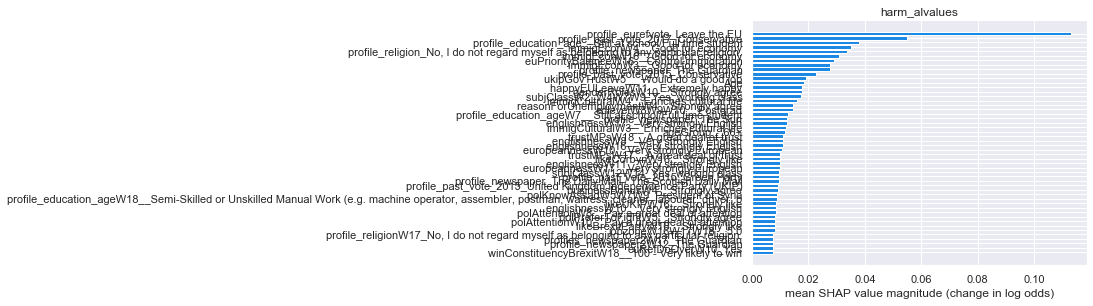

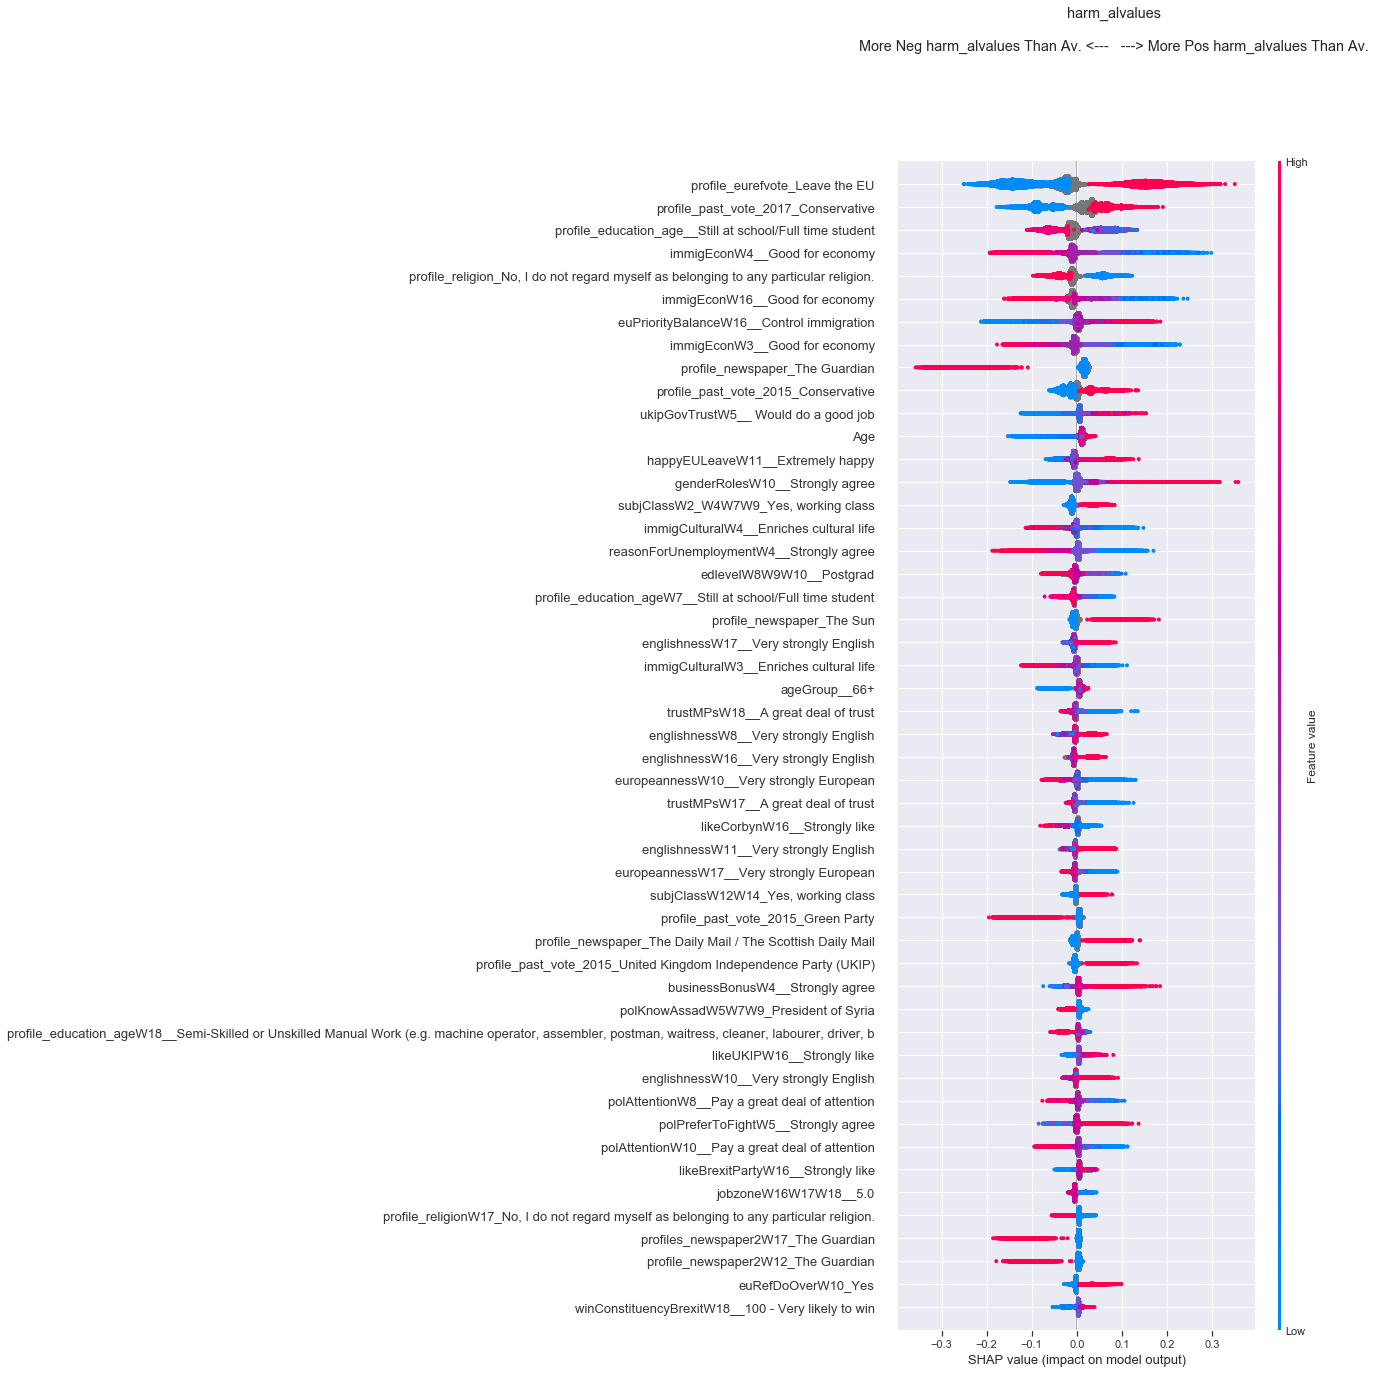

Wall time: 1h 45min 57s


In [93]:
%%time
# base = "redistSelfW1"

Treatment = "predicted_al_values"
var1 = "harm_alvalues"
# BES_reduced_with_na[var1]= Age_at_W1

base = "harm_alvalues"

# var1 = match(BES_reduced_with_na,base).index[0]

# mask = BES_reduced_with_na[var1].notnull()
# mask.loc[mask.index[::2]] = False

df = BES_reduced_with_na.loc[train_entries,decent_sample_cols].astype('float32')
df[var1] = pan_dataset_allr_values.loc[train_entries,'Social: Liberalism <-> Conservatism{gaussian-ish}']
# df[BES_vals.columns] = BES_vals[train_entries]
# df_temp = pd.get_dummies( BES_Panel[match(BES_Panel,"ageGroup|profile_household_children[^W]|edlevel|profile_education_age[^W]|profile_sexualityW10|sexualityW17|profile_religion[^W]").index] )
# df[df_temp.columns] = df_temp

# df[var1] = Age_at_W1[mask]

var_stub = var1

var_list = [var_stub]
var_stub_list = [var_stub]

(explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
# treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

In [94]:
%%time
df= BES_reduced_with_na.loc[genuine_missing_values,decent_sample_cols].astype('float32')
# df[BES_vals.columns] = BES_vals[genuine_missing_values]
al_broad_3 = alg.predict(df)

Wall time: 8.82 s


In [95]:
%%time
df= BES_reduced_with_na.loc[narrow_missing_values,decent_sample_cols].astype('float32')
# df[BES_vals.columns] = BES_vals[narrow_missing_values]
al_broad_4 = alg.predict(df)

Wall time: 4.32 s


[13:55:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.08894
Will train until validation_0-rmse hasn't improved in 59.7 rounds.
[1]	validation_0-rmse:1.06157
[2]	validation_0-rmse:1.03502
[3]	validation_0-rmse:1.00908
[4]	validation_0-rmse:0.983898
[5]	validation_0-rmse:0.959559
[6]	validation_0-rmse:0.935608
[7]	validation_0-rmse:0.91238
[8]	validation_0-rmse:0.889798
[9]	validation_0-rmse:0.867913
[10]	validation_0-rmse:0.846614
[11]	validation_0-rmse:0.825698
[12]	validation_0-rmse:0.805335
[13]	validation_0-rmse:0.785662
[14]	validation_0-rmse:0.766619
[15]	validation_0-rmse:0.747929
[16]	validation_0-rmse:0.729739
[17]	validation_0-rmse:0.712007
[18]	validation_0-rmse:0.694846
[19]	validation_0-rmse:0.678086
[20]	validation_0-rmse:0.661829
[21]	validation_0-rmse:0.645957
[22]	validation_0-rmse:0.630511
[23]	validation_0-rmse:0.615508
[24]	validation_0-rmse:0.600989
[25]	validation_0-rmse:0.586798


[247]	validation_0-rmse:0.066666
[248]	validation_0-rmse:0.066574
[249]	validation_0-rmse:0.066462
[250]	validation_0-rmse:0.066391
[251]	validation_0-rmse:0.066321
[252]	validation_0-rmse:0.066204
[253]	validation_0-rmse:0.066098
[254]	validation_0-rmse:0.066015
[255]	validation_0-rmse:0.065946
[256]	validation_0-rmse:0.065857
[257]	validation_0-rmse:0.065769
[258]	validation_0-rmse:0.065674
[259]	validation_0-rmse:0.06559
[260]	validation_0-rmse:0.065503
[261]	validation_0-rmse:0.06545
[262]	validation_0-rmse:0.065353
[263]	validation_0-rmse:0.06525
[264]	validation_0-rmse:0.065159
[265]	validation_0-rmse:0.065068
[266]	validation_0-rmse:0.064969
[267]	validation_0-rmse:0.064911
[268]	validation_0-rmse:0.064793
[269]	validation_0-rmse:0.064712
[270]	validation_0-rmse:0.064602
[271]	validation_0-rmse:0.064515
[272]	validation_0-rmse:0.06443
[273]	validation_0-rmse:0.064369
[274]	validation_0-rmse:0.064293
[275]	validation_0-rmse:0.064201
[276]	validation_0-rmse:0.064124
[277]	validati

[496]	validation_0-rmse:0.052475
[497]	validation_0-rmse:0.052442
[498]	validation_0-rmse:0.052393
[499]	validation_0-rmse:0.052371
[500]	validation_0-rmse:0.05234
[501]	validation_0-rmse:0.052305
[502]	validation_0-rmse:0.052263
[503]	validation_0-rmse:0.052232
[504]	validation_0-rmse:0.052201
[505]	validation_0-rmse:0.052175
[506]	validation_0-rmse:0.052131
[507]	validation_0-rmse:0.052104
[508]	validation_0-rmse:0.052071
[509]	validation_0-rmse:0.052025
[510]	validation_0-rmse:0.051981
[511]	validation_0-rmse:0.051946
[512]	validation_0-rmse:0.051924
[513]	validation_0-rmse:0.051875
[514]	validation_0-rmse:0.051844
[515]	validation_0-rmse:0.051816
[516]	validation_0-rmse:0.051777
[517]	validation_0-rmse:0.051754
[518]	validation_0-rmse:0.051716
[519]	validation_0-rmse:0.051677
[520]	validation_0-rmse:0.051641
[521]	validation_0-rmse:0.051603
[522]	validation_0-rmse:0.051579
[523]	validation_0-rmse:0.051556
[524]	validation_0-rmse:0.051531
[525]	validation_0-rmse:0.05149
[526]	valida

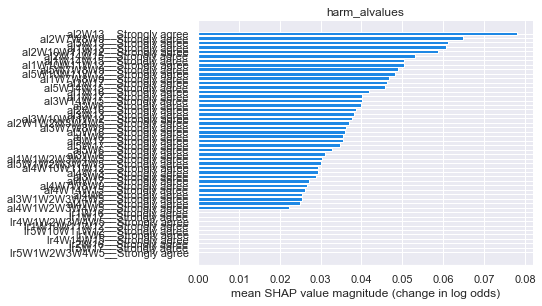

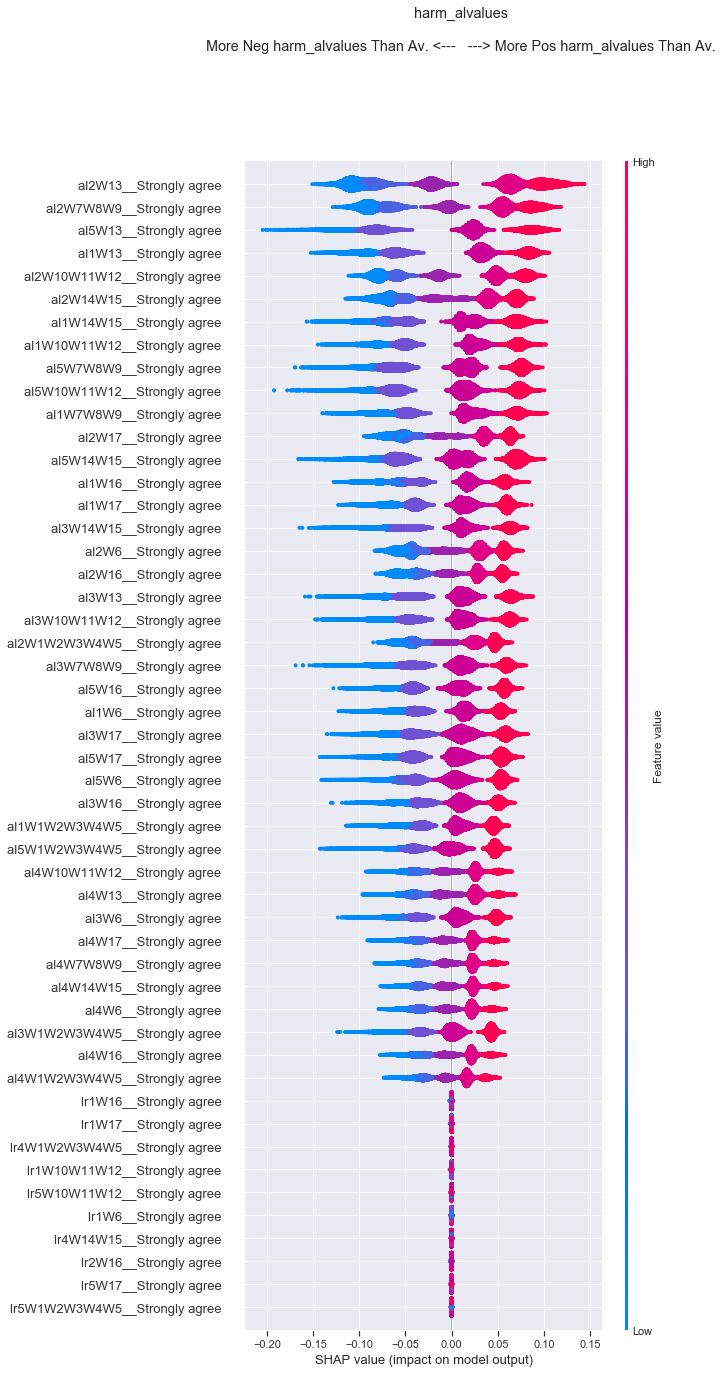

Wall time: 45min 44s


In [104]:
%%time
# base = "redistSelfW1"

Treatment = "predicted_al_values"
var1 = "harm_alvalues"
# BES_reduced_with_na[var1]= Age_at_W1

base = "harm_alvalues"

# var1 = match(BES_reduced_with_na,base).index[0]

# mask = BES_reduced_with_na[var1].notnull()
# mask.loc[mask.index[::2]] = False

df = pd.DataFrame(index=BES_reduced_with_na.index[train_entries])
df[var1] = pan_dataset_allr_values.loc[train_entries,'Social: Liberalism <-> Conservatism{gaussian-ish}']
df[BES_vals.columns] = BES_vals[train_entries]
# df_temp = pd.get_dummies( BES_Panel[match(BES_Panel,"ageGroup|profile_household_children[^W]|edlevel|profile_education_age[^W]|profile_sexualityW10|sexualityW17|profile_religion[^W]").index] )
# df[df_temp.columns] = df_temp

# df[var1] = Age_at_W1[mask]

var_stub = var1

var_list = [var_stub]
var_stub_list = [var_stub]

(explainer, shap_values, train_columns, alg) = xgboost_run(subdir=Treatment,min_features = min(BES_reduced_with_na.shape[1]-1,50),
           title = var_stub+"\n\nMore Neg "+base+" Than Av. <---   ---> More Pos "+base+" Than Av.", Treatment=Treatment)
# treatment_dict[Treatment]  =shap_array(shap_values, train_columns, threshold = .1, min_features = 50)

In [109]:
%%time
# df= BES_reduced_with_na.loc[genuine_missing_values,decent_sample_cols].astype('float32')
# df = pd.DataFrame(index=BES_reduced_with_na.index[train_entries])
# df[BES_vals.columns] = BES_vals[genuine_missing_values]
al_broad_1 = alg.predict(BES_vals[genuine_missing_values])

Wall time: 83 ms


In [110]:
%%time
# df= BES_reduced_with_na.loc[narrow_missing_values,decent_sample_cols].astype('float32')
# df = pd.DataFrame(index=BES_reduced_with_na.index[train_entries])
# df[BES_vals.columns] = BES_vals[narrow_missing_values]
# al_broad_2 = alg.predict(df)
al_broad_2 = alg.predict(BES_vals[narrow_missing_values])

Wall time: 59 ms


In [156]:
pan_dataset_allr_values.columns[2]

'Economic: Left <-> Right{gaussian-ish}'

In [141]:
pan_dataset_allr_values[pan_dataset_allr_values.columns[2]].isnull().sum()

2665

In [204]:
(genuine_missing_values&~narrow_missing_values_lr)

0        False
1        False
2        False
3        False
4        False
         ...  
97153    False
97154    False
97155    False
97156    False
97157    False
Length: 97158, dtype: bool

In [218]:
narrow_missing_values_lr = BES_vals[lr_values].isnull().all(axis=1) & ~nowtsW19
narrow_missing_values_al = BES_vals[al_values].isnull().all(axis=1) & ~nowtsW19

In [223]:
(~narrow_missing_values_lr[genuine_missing_values]).sum(),(genuine_missing_values&~narrow_missing_values_lr).sum()
# mask.sum()
# 2036
# (genuine_missing_values&~narrow_missing_values).sum()


(259, 259)

In [220]:
pan_dataset_allr_values

,Economic: Left(0) <-> Right(200){uniform},Social: Liberalism(0) <-> Conservatism(200){uniform},Economic: Left <-> Right{gaussian-ish},Social: Liberalism <-> Conservatism{gaussian-ish},id,Economic: Left <-> Right{gaussian-ish}completish
0,3.0,184.0,-2.152308,1.391822,16208,-2.152308
1,72.0,90.0,-0.335079,-0.106332,16546,-0.335079
2,77.0,193.0,-0.271574,1.708178,66250,-0.271574
3,87.0,22.0,-0.145436,-1.291703,32741,-0.145436
4,42.0,155.0,-0.789848,0.803508,70863,-0.789848
...,...,...,...,...,...,...
97153,34.0,127.0,-0.950869,0.396305,1306,-0.950869
97154,156.0,123.0,0.751953,0.346286,40381,0.751953
97155,164.0,123.0,0.893627,0.344307,54315,0.893627
97156,137.0,115.0,0.460519,0.240090,26708,0.460519


In [224]:
mask = (genuine_missing_values&~narrow_missing_values_lr)
pan_dataset_allr_values[pan_dataset_allr_values.columns[2]+'completish'] = pan_dataset_allr_values[pan_dataset_allr_values.columns[2]]
pan_dataset_allr_values[pan_dataset_allr_values.columns[2]+'completish'][mask] = lr_broad_1[~narrow_missing_values_lr[genuine_missing_values]]

In [225]:
pan_dataset_allr_values[pan_dataset_allr_values.columns[2]+'complete'] = pan_dataset_allr_values[pan_dataset_allr_values.columns[2]+'completish']
pan_dataset_allr_values[pan_dataset_allr_values.columns[2]+'complete'][narrow_missing_values] = lr_broad_4

In [226]:
mask = (genuine_missing_values&~narrow_missing_values_al)
allr_col = pan_dataset_allr_values.columns[3] # lib-con
pan_dataset_allr_values[allr_col+'completish'] = pan_dataset_allr_values[allr_col]
pan_dataset_allr_values[allr_col+'completish'][mask] = al_broad_1[~narrow_missing_values_al[genuine_missing_values]]

In [227]:
pan_dataset_allr_values[allr_col+'complete'] = pan_dataset_allr_values[allr_col+'completish']
pan_dataset_allr_values[allr_col+'complete'][narrow_missing_values] = al_broad_4

In [228]:
pan_dataset_allr_values#.isnull().sum()

,Economic: Left(0) <-> Right(200){uniform},Social: Liberalism(0) <-> Conservatism(200){uniform},Economic: Left <-> Right{gaussian-ish},Social: Liberalism <-> Conservatism{gaussian-ish},id,Economic: Left <-> Right{gaussian-ish}completish,Economic: Left <-> Right{gaussian-ish}complete,Social: Liberalism <-> Conservatism{gaussian-ish}completish,Social: Liberalism <-> Conservatism{gaussian-ish}complete
0,3.0,184.0,-2.152308,1.391822,16208,-2.152308,-2.152308,1.391822,1.391822
1,72.0,90.0,-0.335079,-0.106332,16546,-0.335079,-0.335079,-0.106332,-0.106332
2,77.0,193.0,-0.271574,1.708178,66250,-0.271574,-0.271574,1.708178,1.708178
3,87.0,22.0,-0.145436,-1.291703,32741,-0.145436,-0.145436,-1.291703,-1.291703
4,42.0,155.0,-0.789848,0.803508,70863,-0.789848,-0.789848,0.803508,0.803508
...,...,...,...,...,...,...,...,...,...
97153,34.0,127.0,-0.950869,0.396305,1306,-0.950869,-0.950869,0.396305,0.396305
97154,156.0,123.0,0.751953,0.346286,40381,0.751953,0.751953,0.346286,0.346286
97155,164.0,123.0,0.893627,0.344307,54315,0.893627,0.893627,0.344307,0.344307
97156,137.0,115.0,0.460519,0.240090,26708,0.460519,0.460519,0.240090,0.240090


In [233]:
pan_dataset_allr_values = pan_dataset_allr_values.set_index("id").sort_index()
pan_dataset_allr_values.to_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')

In [ ]:
# pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_valuesW19"+".csv")

Social: Liberalism <-> Conservatism{gaussian-ish}complete


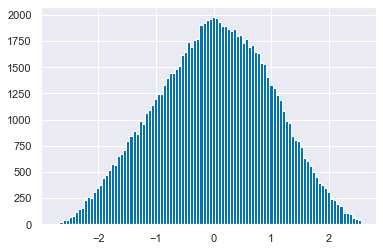

In [235]:
pan_dataset_allr_values[pan_dataset_allr_values.columns[7]].hist(bins=100)
print(pan_dataset_allr_values.columns[7])

Economic: Left <-> Right{gaussian-ish}complete


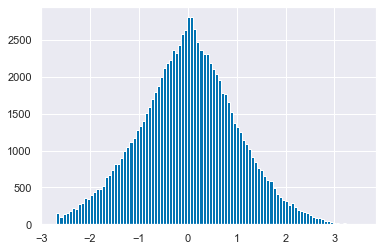

In [236]:
pan_dataset_allr_values[pan_dataset_allr_values.columns[5]].hist(bins=100)
print(pan_dataset_allr_values.columns[5])

In [179]:
pan_dataset_allr_values.columns

Index(['Economic: Left(0) <-> Right(200){uniform}',
       'Social: Liberalism(0) <-> Conservatism(200){uniform}',
       'Economic: Left <-> Right{gaussian-ish}',
       'Social: Liberalism <-> Conservatism{gaussian-ish}',
       'Economic: Left <-> Right{gaussian-ish}completish',
       'Economic: Left <-> Right{gaussian-ish}complete',
       'Social: Liberalism <-> Conservatism{gaussian-ish}completish',
       'Social: Liberalism <-> Conservatism{gaussian-ish}complete'],
      dtype='object')

Economic: Left <-> Right{gaussian-ish}


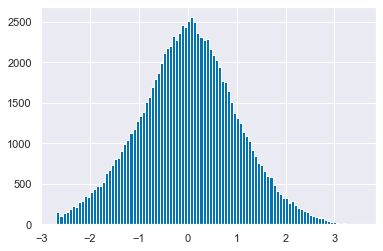

In [180]:
pan_dataset_allr_values[pan_dataset_allr_values.columns[2]].hist(bins=100)
print(pan_dataset_allr_values.columns[2])

Social: Liberalism <-> Conservatism{gaussian-ish}


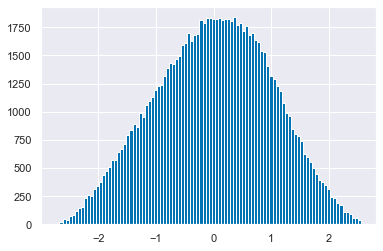

In [181]:
pan_dataset_allr_values[pan_dataset_allr_values.columns[3]].hist(bins=100)
print(pan_dataset_allr_values.columns[3])

In [191]:
pan_dataset_allr_values.columns

Index(['Economic: Left(0) <-> Right(200){uniform}',
       'Social: Liberalism(0) <-> Conservatism(200){uniform}',
       'Economic: Left <-> Right{gaussian-ish}',
       'Social: Liberalism <-> Conservatism{gaussian-ish}',
       'Economic: Left <-> Right{gaussian-ish}completish',
       'Economic: Left <-> Right{gaussian-ish}complete',
       'Social: Liberalism <-> Conservatism{gaussian-ish}completish',
       'Social: Liberalism <-> Conservatism{gaussian-ish}complete'],
      dtype='object')

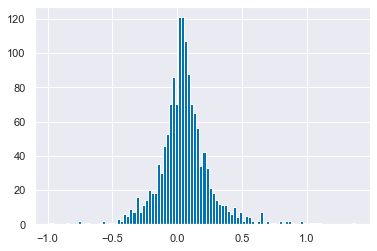

In [186]:
pd.Series(lr_broad_4).hist(bins=100)

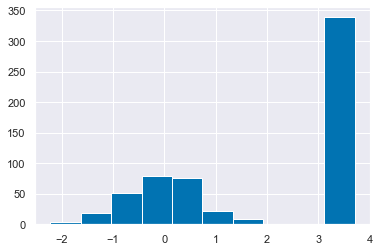

In [195]:
pd.Series(lr_broad_1[~narrow_missing_values[genuine_missing_values]]).hist()

In [197]:
BES_vals[lr_values]

,lr1W6__Strongly agree,lr2W6__Strongly agree,lr3W6__Strongly agree,lr4W6__Strongly agree,lr5W6__Strongly agree,lr1W13__Strongly agree,lr2W13__Strongly agree,lr3W13__Strongly agree,lr4W13__Strongly agree,lr5W13__Strongly agree,...,lr1W7W8W9__Strongly agree,lr2W7W8W9__Strongly agree,lr3W7W8W9__Strongly agree,lr4W7W8W9__Strongly agree,lr5W7W8W9__Strongly agree,lr1W10W11W12__Strongly agree,lr2W10W11W12__Strongly agree,lr3W10W11W12__Strongly agree,lr4W10W11W12__Strongly agree,lr5W10W11W12__Strongly agree
0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,2.0,2.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,4.0,...,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0
2,2.0,3.0,3.0,4.0,3.0,1.0,4.0,3.0,4.0,3.0,...,2.0,4.0,4.0,4.0,3.0,1.0,4.0,3.0,4.0,3.0
3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0
4,3.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,...,2.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97153,4.0,4.0,4.0,4.0,4.0,1.0,3.0,3.0,3.0,2.0,...,4.0,3.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,3.0
97154,1.0,4.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,1.0,3.0,1.0,3.0,3.0,2.0,3.0,2.0,3.0,3.0
97155,2.0,3.0,3.0,2.0,1.0,3.0,1.0,4.0,2.0,3.0,...,1.0,2.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0
97156,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,...,2.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,2.0,3.0


1697

In [199]:
narrow_missing_values = BES_vals.isnull().all(axis=1) & ~nowtsW19
narrow_missing_values.sum()

1438

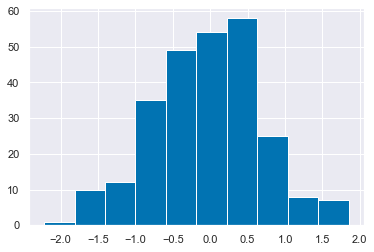

In [206]:
pd.Series(lr_broad_1[~narrow_missing_values_lr[genuine_missing_values]]).hist()

In [237]:
BES_reduced_with_na[ list(search(BES_reduced_with_na,"zeroSum").index)+['profile_eurefvote_Leave the EU'] ].astype('float32').dropna().corr()["profile_eurefvote_Leave the EU"]

zeroSum7W14__Strongly agree       0.087904
zeroSum11W14__Strongly agree     -0.055618
zeroSum5W14__Strongly agree      -0.019884
zeroSum9W14__Strongly agree      -0.085855
zeroSum1W14__Strongly agree       0.093889
zeroSum4W14__Strongly agree       0.189043
zeroSumIRTW14                    -0.128010
profile_eurefvote_Leave the EU    1.000000
Name: profile_eurefvote_Leave the EU, dtype: float64

In [240]:
BES_reduced_with_na[ list(search(BES_reduced_with_na,"locus|tolUncertain").index)+['profile_eurefvote_Leave the EU'] ].astype('float32').dropna().corr()["profile_eurefvote_Leave the EU"]
# search(BES_reduced_with_na,"locus|tolUncertain")

locus1W8__Strongly agree           0.090756
locus2W8__Strongly agree           0.016028
tolUncertain1W8__Strongly agree   -0.023645
tolUncertain2W8__Strongly agree   -0.052828
tolUncertain3W8__Strongly agree    0.021007
locus1W9__Strongly agree           0.032507
locus2W9__Strongly agree           0.030626
profile_eurefvote_Leave the EU     1.000000
Name: profile_eurefvote_Leave the EU, dtype: float64

In [244]:
BES_reduced_with_na[ list(search(BES_reduced_with_na,"locus|tolUncertain").index)+['al_scaleW7W8W9__Authoritarian'] ].astype('float32').dropna().corr()["al_scaleW7W8W9__Authoritarian"]
# search(BES_reduced_with_na,"locus|tolUncertain")
# search(BES_reduced_with_na,"al_scale")

locus1W8__Strongly agree           0.135608
locus2W8__Strongly agree           0.071681
tolUncertain1W8__Strongly agree    0.136954
tolUncertain2W8__Strongly agree    0.118534
tolUncertain3W8__Strongly agree    0.190830
locus1W9__Strongly agree           0.067512
locus2W9__Strongly agree           0.062865
al_scaleW7W8W9__Authoritarian      1.000000
Name: al_scaleW7W8W9__Authoritarian, dtype: float64